In [57]:
cd '/home/jovyan/GA_DSI/Projects/capstone'

/home/jovyan/GA_DSI/Projects/capstone


In [58]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from IPython.display import display
from sys import getsizeof
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# storing data directories for this notebook.
img_out_dir = 'data/images/EDA_NB1_emoji_encoding/'
data_out_dir = 'data/pickled/EDA_NB1_emoji_encoding/'

# used to prin t word cloud in twitter bird shape.
from PIL import Image
wc_image_mask = np.array(Image.open('data/twitter.png'))

%matplotlib inline

## Airline Sentiment Classification

Dataset Description from Kaggle:<br>
Classifies customer sentiment towards major U.S. airlines, based on twitter data. Tweets were scraped from February of 2015 and contributors were asked to classify tweets by positive, negative, and neutral categories, followed by categorizing negative reasons (such as “late flight” or “rude service”).

The Kaggle Dataset contains tweets and categories for 14,640k airline related tweets, classified into one of 3 sentiment categories (positive, negative, neutral). 
<br>Let's see if I can accurately classify the tweet sentiment category based on the text.


### EDA on last 6640 rows of dataset. Had to split rows since calculating the sum of the columns<br>used to kill the kernel.

In [82]:
# reading in 8000 rows but dataset has 14640. I get performance issues.

In [59]:
air_full_df = pd.read_csv("data/csvfiles/kaggle_airline_dataset.csv", encoding='utf-8', nrows=8000)

In [4]:
air_full_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# data size of full kaggle dataset.
air_full_df.shape

(8000, 15)

In [6]:
air_full_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [7]:
air_full_df.airline_sentiment.value_counts()

negative    4560
neutral     1954
positive    1486
Name: airline_sentiment, dtype: int64

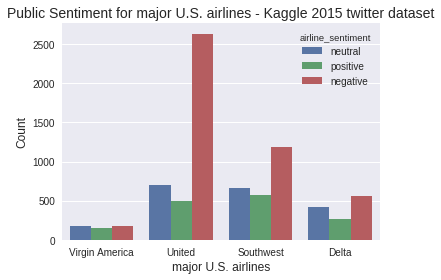

In [8]:
# Airline sentiment.
sns.countplot(x="airline", hue="airline_sentiment", data=air_full_df)
plt.title('Public Sentiment for major U.S. airlines - Kaggle 2015 twitter dataset',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_airline_sentiment_hist.png')

In [9]:
# What are reasons for customer dissatisfaction?
# Explore this to make recommendations at the end from findings.

In [10]:
# plot negative reason value_counts.
neg_reason = air_full_df.negativereason[air_full_df.negativereason.notnull()]
neg_reason.value_counts()

Customer Service Issue         1233
Late Flight                     864
Can't Tell                      680
Lost Luggage                    396
Cancelled Flight                384
Bad Flight                      362
Flight Booking Problems         258
Flight Attendant Complaints     250
longlines                        92
Damaged Luggage                  41
Name: negativereason, dtype: int64

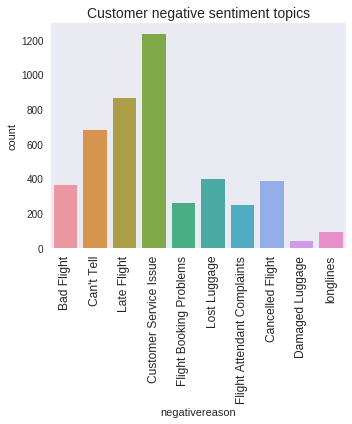

In [11]:
plt.figure(figsize=(5,6))
sns.countplot(x="negativereason", data=air_full_df)
plt.grid(0)
plt.xticks(rotation = 90, fontsize=12)
plt.title("Customer negative sentiment topics", fontsize=14)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_customer_neg_sent_topics_hist.png')

In [12]:
# airlines 
air_full_df.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta'], dtype=object)

In [13]:
# data types
air_full_df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [14]:
# check for null values.
air_full_df.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  3440
negativereason_confidence       2628
airline                            0
airline_sentiment_gold          7983
name                               0
negativereason_gold             7987
retweet_count                      0
text                               0
tweet_coord                     7388
tweet_created                      0
tweet_location                  2478
user_timezone                   2536
dtype: int64

In [15]:
# get subset with cols = ['airline', 'text', 'airline_sentiment', 'airline_sentiment:confidence']

In [60]:
sub_cols = ['text', 'airline_sentiment', 'airline_sentiment_confidence', 
            'negativereason', 'airline']
air_sub_df = air_full_df.loc[:, sub_cols]

In [61]:
del air_full_df

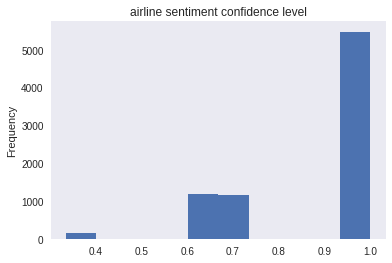

In [18]:
# look at the confidence of values for the 3 categories.
air_sub_df.airline_sentiment_confidence.plot(kind='hist', title='airline sentiment confidence level')
plt.grid(0)

In [99]:
(air_sub_df.airline_sentiment_confidence >= 0.7).sum(), air_sub_df.shape

(5112, (6640, 5))

In [100]:
# let's only keep tweets where the airline_sentiment_confidence is > 0.7

In [62]:
mask = air_sub_df.airline_sentiment_confidence >= 0.7

air_sub_df = air_sub_df.loc[mask,:]

In [63]:
# dataframe with airline sentiment data with 
air_sub_df.shape

(5656, 5)

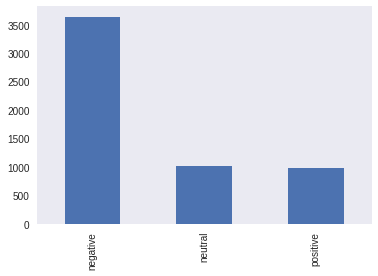

In [21]:
# look at the count of values for the 3 categories.
air_sub_df.airline_sentiment.value_counts().plot(kind='bar')
plt.grid(0)

In [22]:
air_sub_df.head()

,text,airline_sentiment,airline_sentiment_confidence,negativereason,airline
0,@VirginAmerica What @dhepburn said.,neutral,1.0,NaN,Virgin America
3,@VirginAmerica it's really aggressive to blast...,negative,1.0,Bad Flight,Virgin America
4,@VirginAmerica and it's a really big bad thing...,negative,1.0,Can't Tell,Virgin America
5,@VirginAmerica seriously would pay $30 a fligh...,negative,1.0,Can't Tell,Virgin America
9,"@VirginAmerica it was amazing, and arrived an ...",positive,1.0,NaN,Virgin America


In [23]:
air_sub_df[air_sub_df.airline_sentiment == 'positive']['text'][:10]

9     @VirginAmerica it was amazing, and arrived an ...
11    @VirginAmerica I &lt;3 pretty graphics. so muc...
12    @VirginAmerica This is such a great deal! Alre...
14                               @VirginAmerica Thanks!
16    @VirginAmerica So excited for my first cross c...
18                      I ❤️ flying @VirginAmerica. ☺️👍
19    @VirginAmerica you know what would be amazingl...
21    @VirginAmerica I love this graphic. http://t.c...
22    @VirginAmerica I love the hipster innovation. ...
34    @VirginAmerica this is great news!  America co...
Name: text, dtype: object

In [24]:
air_sub_df[air_sub_df.airline_sentiment == 'negative']['text'][:10]

3     @VirginAmerica it's really aggressive to blast...
4     @VirginAmerica and it's a really big bad thing...
5     @VirginAmerica seriously would pay $30 a fligh...
17    @VirginAmerica  I flew from NYC to SFO last we...
24    @VirginAmerica you guys messed up my seating.....
25    @VirginAmerica status match program.  I applie...
26    @VirginAmerica What happened 2 ur vegan food o...
28    @VirginAmerica amazing to me that we can't get...
30    @VirginAmerica hi! I just bked a cool birthday...
32    @VirginAmerica help, left expensive headphones...
Name: text, dtype: object

In [25]:
air_sub_df[air_sub_df.airline_sentiment == 'neutral']['text'][:10]

0                   @VirginAmerica What @dhepburn said.
23    @VirginAmerica will you be making BOS&gt;LAS n...
31    @VirginAmerica Are the hours of operation for ...
42    @VirginAmerica plz help me win my bid upgrade ...
44    @VirginAmerica are flights leaving Dallas for ...
48    @VirginAmerica @ladygaga @carrieunderwood Afte...
52    @VirginAmerica wish you flew out of Atlanta......
53    @VirginAmerica @ladygaga @carrieunderwood Juli...
54    @VirginAmerica Will flights be leaving Dallas ...
58    @VirginAmerica @ladygaga @carrieunderwood - Ca...
Name: text, dtype: object

In [64]:
# target.
y = air_sub_df['airline_sentiment']

In [65]:
# unique values of y.
y.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [66]:
#*********** Let's try to look at the top words in each of the categories, using CountVectorizer() *************

In [67]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [68]:
from nltk.stem.porter import PorterStemmer
import emoji
import string

In [69]:
# exclude name of airlines from the tweets. 
exclude = ['virginamerica', 'united', 'southwestair', 'delta', 'usairways',
           'americanair', 'jetblue', 'southwest', 'flight', 'flights',
           'URL', 'AT_USER', 'amp', 'amp;']

In [70]:
# define stop words. Use the defined 'english' stop words. I will add the airline names to that.
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(exclude)
exclude_punctuation = set(string.punctuation) 

In [71]:
# read in pickled emoji dictionary I created from emojis in the dataset. I want to use
# each emoji as an individual feature.
file = open('data/pickled/Emoticon_NB4/full_emoji_dict.obj','rb')
emoji_dict = pickle.load(file)
            
# I also made a reverse lookup dict.
file = open('data/pickled/Emoticon_NB4/reverse_lookup_full_emoji_dict.obj','rb')
reverse_lookup_emoji_dict = pickle.load(file)            

In [72]:
print(emoji_dict)

{'❤': 'EMOJI_1', '☺': 'EMOJI_2', '👍': 'EMOJI_3', '😡': 'EMOJI_4', '😢': 'EMOJI_5', '💜': 'EMOJI_6', '✈': 'EMOJI_7', '🍷': 'EMOJI_8', '💺': 'EMOJI_9', '😊': 'EMOJI_10', '😍': 'EMOJI_11', '👌': 'EMOJI_12', '💕': 'EMOJI_13', '🌞': 'EMOJI_14', '😃': 'EMOJI_15', '😩': 'EMOJI_16', '😭': 'EMOJI_17', '😎': 'EMOJI_18', '🙉': 'EMOJI_19', '😁': 'EMOJI_20', '❄': 'EMOJI_21', '👏': 'EMOJI_22', '😂': 'EMOJI_23', '💗': 'EMOJI_24', '🍸': 'EMOJI_25', '😒': 'EMOJI_26', '👎': 'EMOJI_27', '😀': 'EMOJI_28', '😄': 'EMOJI_29', '😘': 'EMOJI_30', '👸': 'EMOJI_31', '🎀': 'EMOJI_32', '🌏': 'EMOJI_33', '😥': 'EMOJI_34', '😉': 'EMOJI_35', '✨': 'EMOJI_36', '😱': 'EMOJI_37', '🎉': 'EMOJI_38', '🙌': 'EMOJI_39', '💤': 'EMOJI_40', '😞': 'EMOJI_41', '♥': 'EMOJI_42', '👋': 'EMOJI_43', '✌': 'EMOJI_44', '🙏': 'EMOJI_45', '👿': 'EMOJI_46', '😔': 'EMOJI_47', '🙅': 'EMOJI_48', '🆖': 'EMOJI_49', '💩': 'EMOJI_50', '✔': 'EMOJI_51', '🌴': 'EMOJI_52', '✅': 'EMOJI_53', '❌': 'EMOJI_54', '👠': 'EMOJI_55', '😜': 'EMOJI_56', '😻': 'EMOJI_57', '😕': 'EMOJI_58', '😈': 'EMOJI_59', '😤': 

In [73]:
print(reverse_lookup_emoji_dict)

{'EMOJI_1': '❤', 'EMOJI_2': '☺', 'EMOJI_3': '👍', 'EMOJI_4': '😡', 'EMOJI_5': '😢', 'EMOJI_6': '💜', 'EMOJI_7': '✈', 'EMOJI_8': '🍷', 'EMOJI_9': '💺', 'EMOJI_10': '😊', 'EMOJI_11': '😍', 'EMOJI_12': '👌', 'EMOJI_13': '💕', 'EMOJI_14': '🌞', 'EMOJI_15': '😃', 'EMOJI_16': '😩', 'EMOJI_17': '😭', 'EMOJI_18': '😎', 'EMOJI_19': '🙉', 'EMOJI_20': '😁', 'EMOJI_21': '❄', 'EMOJI_22': '👏', 'EMOJI_23': '😂', 'EMOJI_24': '💗', 'EMOJI_25': '🍸', 'EMOJI_26': '😒', 'EMOJI_27': '👎', 'EMOJI_28': '😀', 'EMOJI_29': '😄', 'EMOJI_30': '😘', 'EMOJI_31': '👸', 'EMOJI_32': '🎀', 'EMOJI_33': '🌏', 'EMOJI_34': '😥', 'EMOJI_35': '😉', 'EMOJI_36': '✨', 'EMOJI_37': '😱', 'EMOJI_38': '🎉', 'EMOJI_39': '🙌', 'EMOJI_40': '💤', 'EMOJI_41': '😞', 'EMOJI_42': '♥', 'EMOJI_43': '👋', 'EMOJI_44': '✌', 'EMOJI_45': '🙏', 'EMOJI_46': '👿', 'EMOJI_47': '😔', 'EMOJI_48': '🙅', 'EMOJI_49': '🆖', 'EMOJI_50': '💩', 'EMOJI_51': '✔', 'EMOJI_52': '🌴', 'EMOJI_53': '✅', 'EMOJI_54': '❌', 'EMOJI_55': '👠', 'EMOJI_56': '😜', 'EMOJI_57': '😻', 'EMOJI_58': '😕', 'EMOJI_59': '😈', 'EMOJ

In [74]:
def encode_emojis(text):
    input_txt = text
    for word in text:
        if word in emoji.UNICODE_EMOJI:
            input_txt = input_txt.replace(word, emoji_dict[word])
    return(input_txt)

In [75]:
def extract_emojis(text):
    return(' '.join(word for word in text if word in emoji.UNICODE_EMOJI))

In [76]:
def tokenize(text):
    return(text.split())

In [77]:
def cleaner(text):
    
    # convert text to lowercase.
    text = text.lower()
    # remove www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # remove @username to AT_USER
    text = re.sub('@[^\s]+','',text)
    # remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    # remove some punctuation symbols.
    text= ''.join(ch for ch in text if ch not in exclude_punctuation)
    # clean
    text = re.sub('&#39;','',text).lower()
    # trim
    text = text.strip('\'"')
    # trim any leading or trailing white spaces.
    text = text.strip()

    return(text)

In [78]:
# remove stopwords.
def remove_stopwords(text):
    '''
    remove english stop words
    '''
    word_lst = tokenize(text)
    out = [word.strip() for word in word_lst if word not in stop_words]   
    
    text = ' '.join(out)
    return(text)

In [79]:
def stemming(text):
    '''
    replaces words with its stem word (ie thanks-> thanks, fly->fli,...)
    '''
    ps = PorterStemmer()
    text = tokenize(text)
    text = ' '.join(ps.stem(word) for word in text)
    return(text)

In [80]:
def declump_emojis_in_text(text):
    em_txt = text        
    for i in text:
        if (i in emoji.UNICODE_EMOJI):
            em_txt = em_txt.replace(i,' '+i)
        
    return(em_txt)

## Clean Text
```(eliminate web tags, punctuation, symbols...)```

In [81]:
air_sub_df.columns

Index(['text', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'airline'],
      dtype='object')

In [82]:
# create a new category 'clean_text' with clean text.
air_sub_df['clean_text'] = air_sub_df['text'].apply(cleaner)

In [83]:
# Let's see what the clean data looks like.

In [26]:
air_sub_df[['clean_text', 'text']][y=='positive'][:10]

,clean_text,text
9,it was amazing and arrived an hour early youre...,"@VirginAmerica it was amazing, and arrived an ..."
11,i lt3 pretty graphics so much better than mini...,@VirginAmerica I &lt;3 pretty graphics. so muc...
12,this is such a great deal already thinking abo...,@VirginAmerica This is such a great deal! Alre...
14,thanks,@VirginAmerica Thanks!
16,so excited for my first cross country flight l...,@VirginAmerica So excited for my first cross c...
18,i ❤️ flying ☺️👍,I ❤️ flying @VirginAmerica. ☺️👍
19,you know what would be amazingly awesome bosfl...,@VirginAmerica you know what would be amazingl...
21,i love this graphic,@VirginAmerica I love this graphic. http://t.c...
22,i love the hipster innovation you are a feel g...,@VirginAmerica I love the hipster innovation. ...
34,this is great news america could start flights...,@VirginAmerica this is great news! America co...


In [27]:
air_sub_df.loc[18, 'text'], air_sub_df.loc[19, 'text']

('I ❤️ flying @VirginAmerica. ☺️👍',
 '@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.')

In [28]:
air_sub_df.loc[18, 'clean_text'], air_sub_df.loc[19, 'clean_text']

('i ❤️ flying ☺️👍',
 'you know what would be amazingly awesome bosfll please i want to fly with only you')

In [29]:
air_sub_df[['clean_text', 'text']][y=='negative'][:10]

,clean_text,text
3,its really aggressive to blast obnoxious enter...,@VirginAmerica it's really aggressive to blast...
4,and its a really big bad thing about it,@VirginAmerica and it's a really big bad thing...
5,seriously would pay 30 a flight for seats that...,@VirginAmerica seriously would pay $30 a fligh...
17,i flew from nyc to sfo last week and couldnt f...,@VirginAmerica I flew from NYC to SFO last we...
24,you guys messed up my seating i reserved seati...,@VirginAmerica you guys messed up my seating.....
25,status match program i applied and its been th...,@VirginAmerica status match program. I applie...
26,what happened 2 ur vegan food options at least...,@VirginAmerica What happened 2 ur vegan food o...
28,amazing to me that we cant get any cold air fr...,@VirginAmerica amazing to me that we can't get...
30,hi i just bked a cool birthday trip with you b...,@VirginAmerica hi! I just bked a cool birthday...
32,help left expensive headphones on flight 89 ia...,"@VirginAmerica help, left expensive headphones..."


In [30]:
air_sub_df.loc[3, 'text'] 

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

In [43]:
air_sub_df.loc[3, 'clean_text']

'its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse'

In [32]:
air_sub_df[['clean_text', 'text']][y=='neutral'][:10]

,clean_text,text
0,what said,@VirginAmerica What @dhepburn said.
23,will you be making bosgtlas non stop permanent...,@VirginAmerica will you be making BOS&gt;LAS n...
31,are the hours of operation for the club at sfo...,@VirginAmerica Are the hours of operation for ...
42,plz help me win my bid upgrade for my flight 2...,@VirginAmerica plz help me win my bid upgrade ...
44,are flights leaving dallas for seattle on time...,@VirginAmerica are flights leaving Dallas for ...
48,after last night tribute soundofmusic oscars20...,@VirginAmerica @ladygaga @carrieunderwood Afte...
52,wish you flew out of atlanta soon,@VirginAmerica wish you flew out of Atlanta......
53,julie andrews hands down,@VirginAmerica @ladygaga @carrieunderwood Juli...
54,will flights be leaving dallas for la on febru...,@VirginAmerica Will flights be leaving Dallas ...
58,carrie,@VirginAmerica @ladygaga @carrieunderwood - Ca...


In [33]:
air_sub_df.loc[44, 'text']

'@VirginAmerica are flights leaving Dallas for Seattle on time Feb 24?'

In [34]:
air_sub_df.loc[44, 'clean_text']

'are flights leaving dallas for seattle on time feb 24'

In [35]:
# users clump emojis together with words. I want to vectorize them as 
# separate individual features - where each unique emoji in training corpus 
# is a feature. 

# NOTE: later maybe I should change this so many more emojis are incorporated as
# features - not just the ones in the training corpus. 

In [84]:
# example of clumped emoji.
air_sub_df.loc[18, 'clean_text']

'i ❤️ flying ☺️👍'

In [85]:
# right now ☺️👍 will be a feature. I want features independent 
# as ☺️ and 👍. Let's declump them.

air_sub_df['clean_text'] = air_sub_df['clean_text'].apply(declump_emojis_in_text)

In [86]:
air_sub_df.loc[18, 'clean_text']

'i  ❤️ flying  ☺️ 👍'

In [47]:
# notice now the emoji is a separate feature.

In [87]:
# Now let's encode the emojis so we can use it in the vectorizer as a feature.
air_sub_df['clean_text'] = air_sub_df['clean_text'].apply(encode_emojis)

In [88]:
air_sub_df.loc[18, 'clean_text']

'i  EMOJI_1️ flying  EMOJI_2️ EMOJI_3'

In [89]:
# The emojis from above are now encoded.

In [90]:
# now I want to create a separate col that stores a list of emojis
# in the text, if any are present. This may be useful for exploring
# sentiment and emoji relationships further.

In [91]:
# create a new category 'emojis' with emojis.
air_sub_df['emojis'] = air_sub_df['text'].apply(extract_emojis)

In [92]:
air_sub_df[air_sub_df['emojis']!=''][:5]

,text,airline_sentiment,airline_sentiment_confidence,negativereason,airline,clean_text,emojis
18,I ❤️ flying @VirginAmerica. ☺️👍,positive,1.0,NaN,Virgin America,i EMOJI_1️ flying EMOJI_2️ EMOJI_3,❤ ☺ 👍
24,@VirginAmerica you guys messed up my seating.....,negative,1.0,Customer Service Issue,Virgin America,you guys messed up my seating i reserved seati...,😡
30,@VirginAmerica hi! I just bked a cool birthday...,negative,1.0,Flight Booking Problems,Virgin America,hi i just bked a cool birthday trip with you b...,😢
36,@VirginAmerica Moodlighting is the only way to...,positive,1.0,NaN,Virgin America,moodlighting is the only way to fly best exper...,💜 ✈
42,@VirginAmerica plz help me win my bid upgrade ...,neutral,1.0,NaN,Virgin America,plz help me win my bid upgrade for my flight 2...,🍷 👍 💺 ✈


## Reduce dimensionality - using english stop words
```(eliminating english stop words that typically don't impart much meaning like prepositions, pronouns... I will also remove twitter handle and urls encoded above, in the cleaner method, as AT_USER and URL.```

In [93]:
# create a new category 'stopw_clean_text' to store reduced dimensionality text,
# by eliminating english stop words.
air_sub_df['stopw_clean_text'] = air_sub_df['clean_text'].apply(remove_stopwords)

In [94]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='positive'][:10]

,stopw_clean_text,clean_text
9,amazing arrived hour early youre good,it was amazing and arrived an hour early youre...
11,lt3 pretty graphics better minimal iconography d,i lt3 pretty graphics so much better than mini...
12,great deal thinking 2nd trip havent gone 1st t...,this is such a great deal already thinking abo...
14,thanks,thanks
16,excited cross country lax mco ive heard great ...,so excited for my first cross country flight l...
18,EMOJI_1️ flying EMOJI_2️ EMOJI_3,i EMOJI_1️ flying EMOJI_2️ EMOJI_3
19,know amazingly awesome bosfll want fly,you know what would be amazingly awesome bosfl...
21,love graphic,i love this graphic
22,love hipster innovation feel good brand,i love the hipster innovation you are a feel g...
34,great news america start hawaii end year,this is great news america could start flights...


In [53]:
air_sub_df.loc[12, 'clean_text']

'this is such a great deal already thinking about my 2nd trip to amp i havent even gone on my 1st trip yet p'

In [54]:
air_sub_df.loc[12, 'stopw_clean_text']

'great deal thinking 2nd trip havent gone 1st trip p'

In [55]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='negative'][:10]

,stopw_clean_text,clean_text
3,really aggressive blast obnoxious entertainmen...,its really aggressive to blast obnoxious enter...
4,really big bad thing,and its a really big bad thing about it
5,seriously pay 30 seats didnt playing really ba...,seriously would pay 30 a flight for seats that...
17,flew nyc sfo week fully sit seat large gentlem...,i flew from nyc to sfo last week and couldnt f...
24,guys messed seating reserved seating friends g...,you guys messed up my seating i reserved seati...
25,status match program applied weeks called emai...,status match program i applied and its been th...
26,happened 2 ur vegan food options say ur site k...,what happened 2 ur vegan food options at least...
28,amazing cold air vents vx358 noair worstflight...,amazing to me that we cant get any cold air fr...
30,hi just bked cool birthday trip add elevate ca...,hi i just bked a cool birthday trip with you b...
32,help left expensive headphones 89 iad lax toda...,help left expensive headphones on flight 89 ia...


In [56]:
air_sub_df.loc[25, 'clean_text']

'status match program i applied and its been three weeks called and emailed with no response'

In [57]:
air_sub_df.loc[25, 'stopw_clean_text']

'status match program applied weeks called emailed response'

In [58]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='neutral'][:10]

,stopw_clean_text,clean_text
0,said,what said
23,making bosgtlas non stop permanently anytime soon,will you be making bosgtlas non stop permanent...
31,hours operation club sfo posted online current,are the hours of operation for the club at sfo...
42,plz help win bid upgrade 227 laxgtsea EMOJI_8 ...,plz help me win my bid upgrade for my flight 2...
44,leaving dallas seattle time feb 24,are flights leaving dallas for seattle on time...
48,night tribute soundofmusic oscars2015 think agree,after last night tribute soundofmusic oscars20...
52,wish flew atlanta soon,wish you flew out of atlanta soon
53,julie andrews hands,julie andrews hands down
54,leaving dallas la february 24th,will flights be leaving dallas for la on febru...
58,carrie,carrie


In [59]:
air_sub_df.loc[42, 'clean_text']

'plz help me win my bid upgrade for my flight 227 laxgtsea  EMOJI_8 EMOJI_3 EMOJI_9 EMOJI_7️'

In [60]:
air_sub_df.loc[42, 'stopw_clean_text']

'plz help win bid upgrade 227 laxgtsea EMOJI_8 EMOJI_3 EMOJI_9 EMOJI_7️'

## Further reduce dimensionality - using stemming 
```(Stemming attempts to find the root of the word by chopping off the end, like thanks becoms thank...)```

In [95]:
# create a new category 'stem_stopw_clean_text' to store reduced dimensionality text,
# by finding root of words.
air_sub_df['stem_stopw_clean_text'] = air_sub_df['stopw_clean_text'].apply(stemming)

In [62]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='positive'][:10]

,stem_stopw_clean_text,stopw_clean_text
9,amaz arriv hour earli your good,amazing arrived hour early youre good
11,lt3 pretti graphic better minim iconographi d,lt3 pretty graphics better minimal iconography d
12,great deal think 2nd trip havent gone 1st trip p,great deal thinking 2nd trip havent gone 1st t...
14,thank,thanks
16,excit cross countri lax mco ive heard great th...,excited cross country lax mco ive heard great ...
18,emoji_1️ fli emoji_2️ emoji_3,EMOJI_1️ flying EMOJI_2️ EMOJI_3
19,know amazingli awesom bosfll want fli,know amazingly awesome bosfll want fly
21,love graphic,love graphic
22,love hipster innov feel good brand,love hipster innovation feel good brand
34,great news america start hawaii end year,great news america start hawaii end year


In [63]:
air_sub_df.loc[19, 'stopw_clean_text']

'know amazingly awesome bosfll want fly'

In [64]:
air_sub_df.loc[19, 'stem_stopw_clean_text']

'know amazingli awesom bosfll want fli'

In [65]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='negative'][:10]

,stem_stopw_clean_text,stopw_clean_text
3,realli aggress blast obnoxi entertain guest fa...,really aggressive blast obnoxious entertainmen...
4,realli big bad thing,really big bad thing
5,serious pay 30 seat didnt play realli bad thin...,seriously pay 30 seats didnt playing really ba...
17,flew nyc sfo week fulli sit seat larg gentlema...,flew nyc sfo week fully sit seat large gentlem...
24,guy mess seat reserv seat friend guy gave seat...,guys messed seating reserved seating friends g...
25,statu match program appli week call email respons,status match program applied weeks called emai...
26,happen 2 ur vegan food option say ur site know...,happened 2 ur vegan food options say ur site k...
28,amaz cold air vent vx358 noair worstflightev r...,amazing cold air vents vx358 noair worstflight...
30,hi just bked cool birthday trip add elev caus ...,hi just bked cool birthday trip add elevate ca...
32,help left expens headphon 89 iad lax today sea...,help left expensive headphones 89 iad lax toda...


In [66]:
air_sub_df.loc[25, 'stopw_clean_text']

'status match program applied weeks called emailed response'

In [67]:
air_sub_df.loc[25, 'stem_stopw_clean_text']

'statu match program appli week call email respons'

In [68]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='neutral'][:10]

,stem_stopw_clean_text,stopw_clean_text
0,said,said
23,make bosgtla non stop perman anytim soon,making bosgtlas non stop permanently anytime soon
31,hour oper club sfo post onlin current,hours operation club sfo posted online current
42,plz help win bid upgrad 227 laxgtsea emoji_8 e...,plz help win bid upgrade 227 laxgtsea EMOJI_8 ...
44,leav dalla seattl time feb 24,leaving dallas seattle time feb 24
48,night tribut soundofmus oscars2015 think agre,night tribute soundofmusic oscars2015 think agree
52,wish flew atlanta soon,wish flew atlanta soon
53,juli andrew hand,julie andrews hands
54,leav dalla la februari 24th,leaving dallas la february 24th
58,carri,carrie


In [69]:
air_sub_df.loc[42, 'stopw_clean_text']

'plz help win bid upgrade 227 laxgtsea EMOJI_8 EMOJI_3 EMOJI_9 EMOJI_7️'

In [70]:
air_sub_df.loc[42, 'stem_stopw_clean_text']

'plz help win bid upgrad 227 laxgtsea emoji_8 emoji_3 emoji_9 emoji_7️'

In [71]:
# Let's make a word cloud to visualize the clean text data.

In [72]:
def make_wordcloud(data, title, filename, mask):
    plt.figure(figsize=(7,7))
    im = WordCloud(max_words=300, mask=mask).generate(' '.join(i for i in data))
    plt.grid(0)
    plt.title(title, fontsize=14)
    im.to_file(img_out_dir+filename)
    plt.imshow(im)

## Positive class

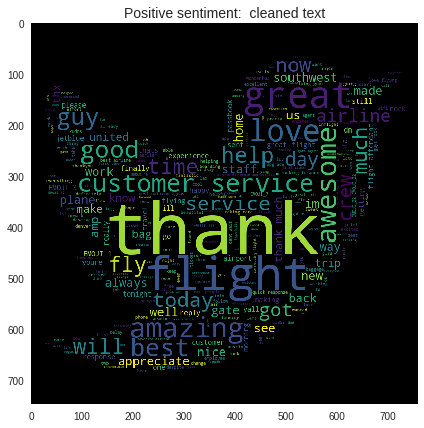

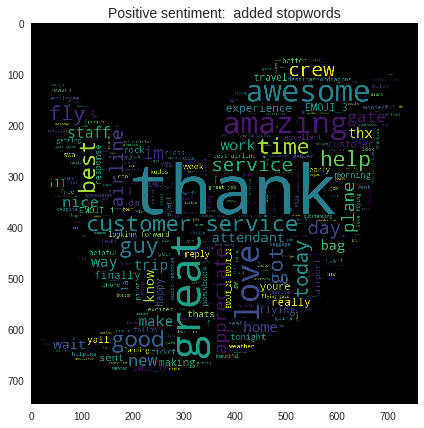

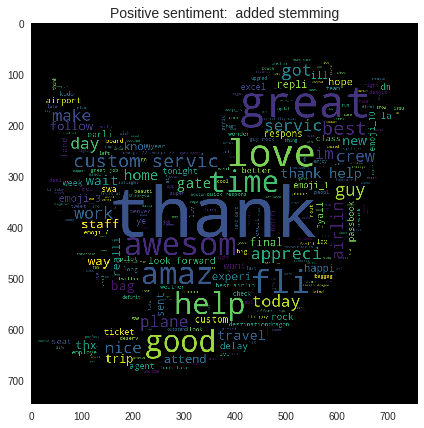

In [73]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='positive']
title = "Positive sentiment:  cleaned text"
filename = 'WordCld_pos_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stopwords"
filename = 'WordCld_pos_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stemming"
filename = 'WordCld_pos_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Negative class

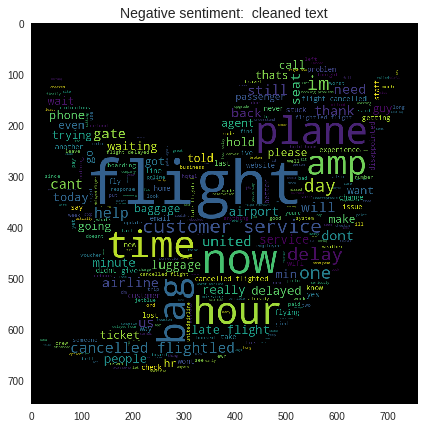

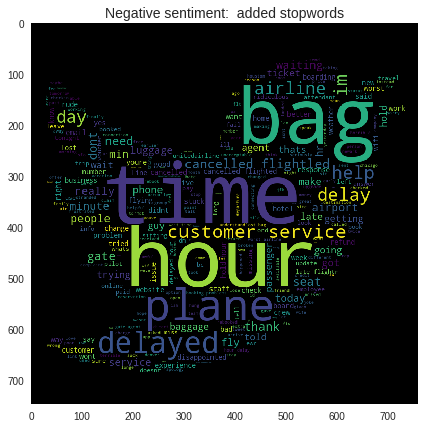

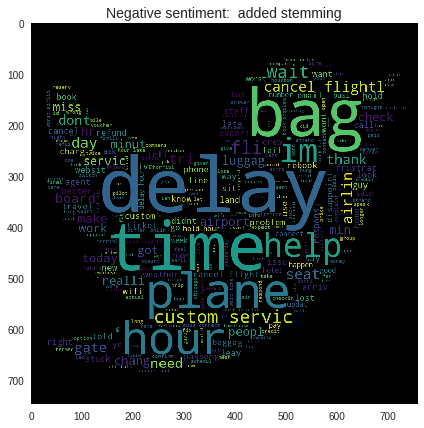

In [74]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='negative']
title = "Negative sentiment:  cleaned text"
filename = 'WordCld_neg_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stopwords"
filename = 'WordCld_neg_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stemming"
filename = 'WordCld_neg_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

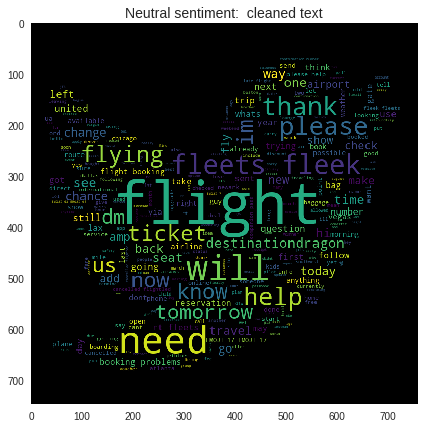

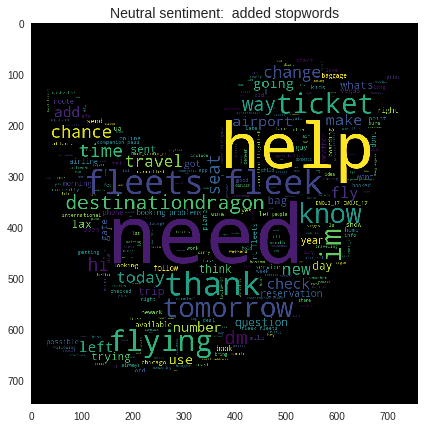

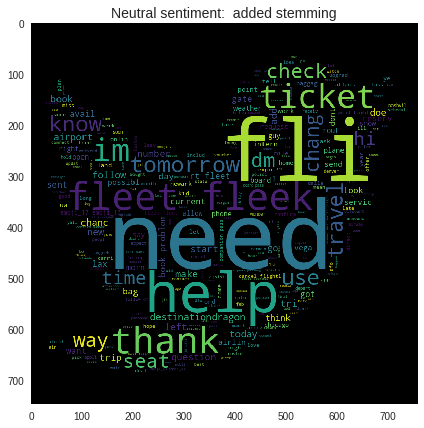

In [75]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='neutral']
title = "Neutral sentiment:  cleaned text"
filename = 'WordCld_neut_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stopwords"
filename = 'WordCld_neut_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stemming"
filename = 'WordCld_neut_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Feature extraction using CountVectorizer() 
```compare results of using 'clean text', 'added stopwords', and 'added stemming'.```<br>
```NOTE: I am passing a custom token pattern to the vectorizers because I want to```<br>
```use the emojis as features.```

## Look at uni-grams 

In [139]:
grams = "Unigrams"

In [140]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(1,1))                     
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(1,1))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(1,1))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y


In [141]:
print(words_df.shape)
words_df.head(4)

(5656, 8647)


,0162431184663,0167560070877,0214,021mbps,02272015,03,0510,0530,0769,10,...,zcc82u,zero,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
print(words_stop_df.shape)
words_stop_df.head(4)

(5656, 8382)


,0162431184663,0167560070877,0214,021mbps,02272015,03,0510,0530,0769,10,...,zcc82u,zero,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
print(words_stem_df.shape)
words_stem_df.head(4)

(5656, 6801)


,0162431184663,0167560070877,0214,021mbp,02272015,03,0510,0530,0769,10,...,yyzua70435,zcc82u,zero,zipper,zombi,zone,zoom,zrh,zuke,zurich
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
# We see that the dimensions of the features reduced from 8647 with clean text, 
# to 8382 with stopwords and 6801 with stemming.

### Positive Sentiment

In [145]:
def disp_positive_grams(words_df, words_stop_df, words_stem_df, grams):

    words_sorted_ordimp = words_df[words_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Positive Sentiment: cleaned text', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_pos_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Positive Sentiment: added stopwords', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_pos_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "positive"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Positive Sentiment: added stemming', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_pos_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)


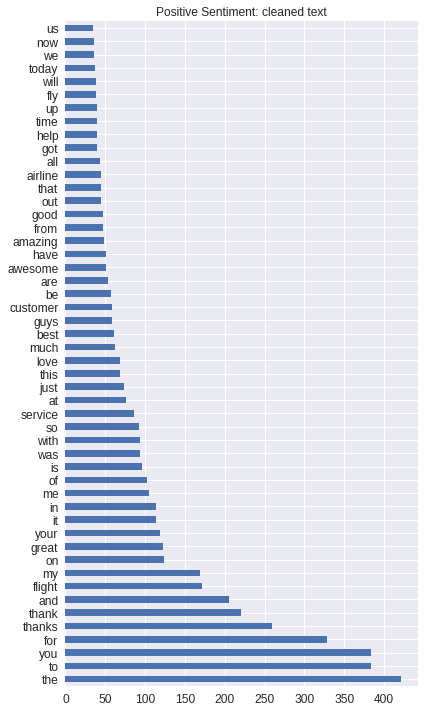

Index(['the', 'to', 'you', 'for', 'thanks', 'thank', 'and', 'flight', 'my',
       'on', 'great', 'your', 'it', 'in', 'me', 'of', 'is', 'was', 'with',
       'so', 'service', 'at', 'just', 'this', 'love', 'much', 'best', 'guys',
       'customer', 'be', 'are', 'awesome', 'have', 'amazing', 'from', 'good',
       'out', 'that', 'airline', 'all', 'got', 'help', 'time', 'up', 'fly',
       'will', 'today', 'we', 'now', 'us'],
      dtype='object')


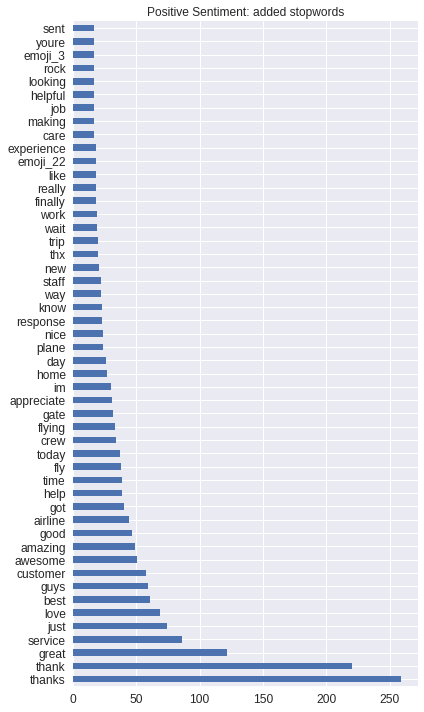

Index(['thanks', 'thank', 'great', 'service', 'just', 'love', 'best', 'guys',
       'customer', 'awesome', 'amazing', 'good', 'airline', 'got', 'help',
       'time', 'fly', 'today', 'crew', 'flying', 'gate', 'appreciate', 'im',
       'home', 'day', 'plane', 'nice', 'response', 'know', 'way', 'staff',
       'new', 'thx', 'trip', 'wait', 'work', 'finally', 'really', 'like',
       'emoji_22', 'experience', 'care', 'making', 'job', 'helpful', 'looking',
       'rock', 'emoji_3', 'youre', 'sent'],
      dtype='object')


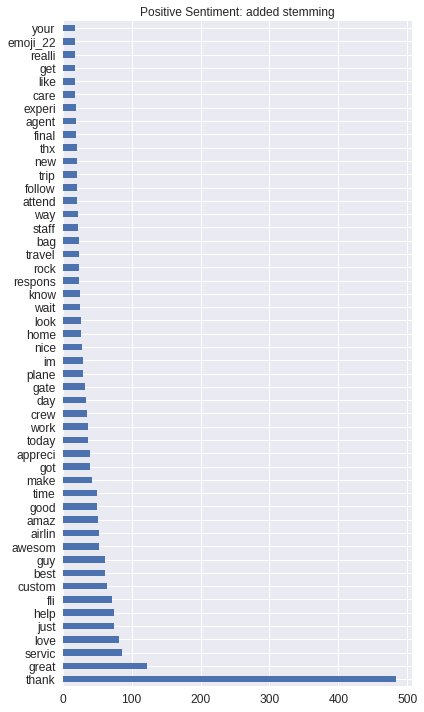

Index(['thank', 'great', 'servic', 'love', 'just', 'help', 'fli', 'custom',
       'best', 'guy', 'awesom', 'airlin', 'amaz', 'good', 'time', 'make',
       'got', 'appreci', 'today', 'work', 'crew', 'day', 'gate', 'plane', 'im',
       'nice', 'home', 'look', 'wait', 'know', 'respons', 'rock', 'travel',
       'bag', 'staff', 'way', 'attend', 'follow', 'trip', 'new', 'thx',
       'final', 'agent', 'experi', 'care', 'like', 'get', 'realli', 'emoji_22',
       'your'],
      dtype='object')


In [146]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

In [147]:
def disp_negative_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Negative Sentiment: cleaned text', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neg_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Negative Sentiment: added stopwords', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neg_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "negative"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Negative Sentiment: added stemming', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neg_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

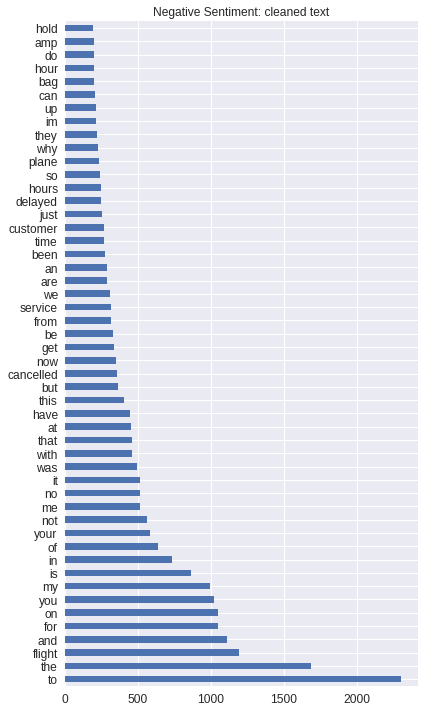

Index(['to', 'the', 'flight', 'and', 'for', 'on', 'you', 'my', 'is', 'in',
       'of', 'your', 'not', 'me', 'no', 'it', 'was', 'with', 'that', 'at',
       'have', 'this', 'but', 'cancelled', 'now', 'get', 'be', 'from',
       'service', 'we', 'are', 'an', 'been', 'time', 'customer', 'just',
       'delayed', 'hours', 'so', 'plane', 'why', 'they', 'im', 'up', 'can',
       'bag', 'hour', 'do', 'amp', 'hold'],
      dtype='object')


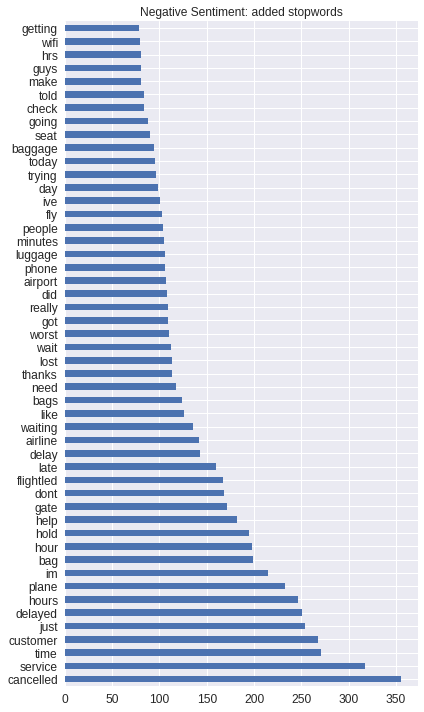

Index(['cancelled', 'service', 'time', 'customer', 'just', 'delayed', 'hours',
       'plane', 'im', 'bag', 'hour', 'hold', 'help', 'gate', 'dont',
       'flightled', 'late', 'delay', 'airline', 'waiting', 'like', 'bags',
       'need', 'thanks', 'lost', 'wait', 'worst', 'got', 'really', 'did',
       'airport', 'phone', 'luggage', 'minutes', 'people', 'fly', 'ive', 'day',
       'trying', 'today', 'baggage', 'seat', 'going', 'check', 'told', 'make',
       'guys', 'hrs', 'wifi', 'getting'],
      dtype='object')


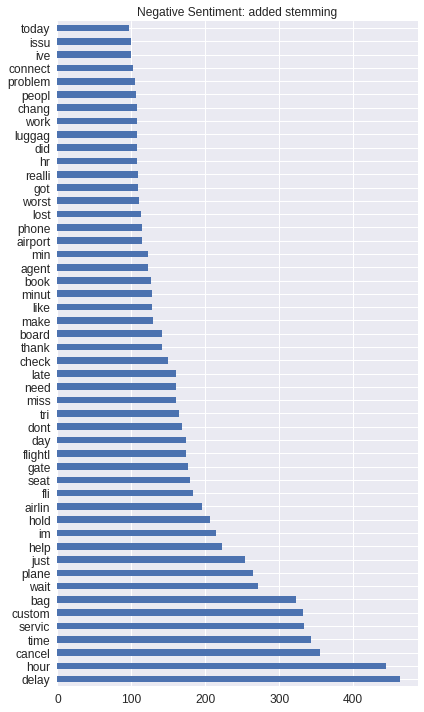

Index(['delay', 'hour', 'cancel', 'time', 'servic', 'custom', 'bag', 'wait',
       'plane', 'just', 'help', 'im', 'hold', 'airlin', 'fli', 'seat', 'gate',
       'flightl', 'day', 'dont', 'tri', 'miss', 'need', 'late', 'check',
       'thank', 'board', 'make', 'like', 'minut', 'book', 'agent', 'min',
       'airport', 'phone', 'lost', 'worst', 'got', 'realli', 'hr', 'did',
       'luggag', 'work', 'chang', 'peopl', 'problem', 'connect', 'ive', 'issu',
       'today'],
      dtype='object')


In [148]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

In [118]:
def disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Neutral Sentiment: cleaned text', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neut_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Neutral Sentiment: added stopwords', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neut_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "neutral"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(50).plot(kind='barh', title='Neutral Sentiment: added stemming', 
                                      figsize=(6,10), fontsize=12)
    plt.tight_layout()
    plt.savefig(img_out_dir+grams+'_neut_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:50].index)

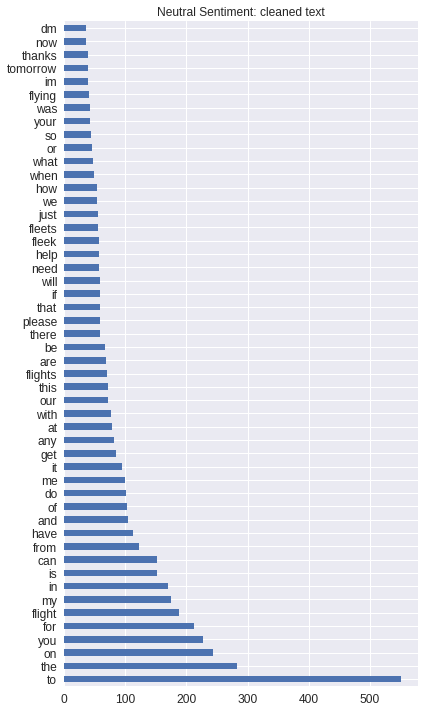

Index(['to', 'the', 'on', 'you', 'for', 'flight', 'my', 'in', 'is', 'can',
       'from', 'have', 'and', 'of', 'do', 'me', 'it', 'get', 'any', 'at',
       'with', 'our', 'this', 'flights', 'are', 'be', 'there', 'please',
       'that', 'if', 'will', 'need', 'help', 'fleek', 'fleets', 'just', 'we',
       'how', 'when', 'what', 'or', 'so', 'your', 'was', 'flying', 'im',
       'tomorrow', 'thanks', 'now', 'dm'],
      dtype='object')


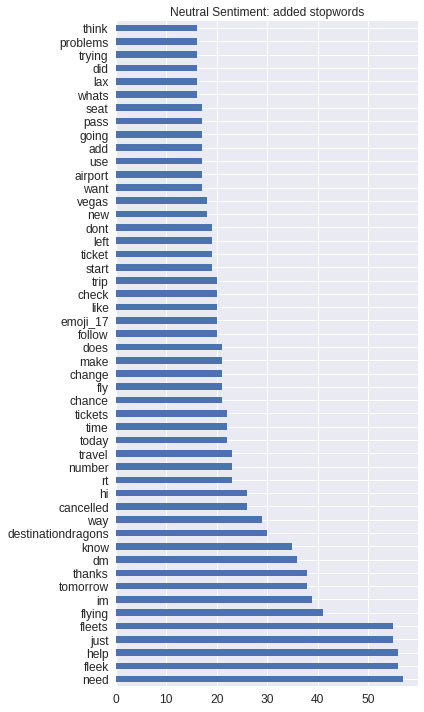

Index(['need', 'fleek', 'help', 'just', 'fleets', 'flying', 'im', 'tomorrow',
       'thanks', 'dm', 'know', 'destinationdragons', 'way', 'cancelled', 'hi',
       'rt', 'number', 'travel', 'today', 'time', 'tickets', 'chance', 'fly',
       'change', 'make', 'does', 'follow', 'emoji_17', 'like', 'check', 'trip',
       'start', 'ticket', 'left', 'dont', 'new', 'vegas', 'want', 'airport',
       'use', 'add', 'going', 'pass', 'seat', 'whats', 'lax', 'did', 'trying',
       'problems', 'think'],
      dtype='object')


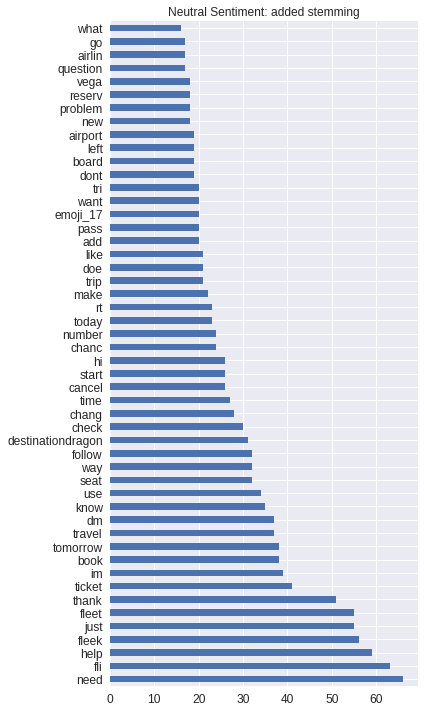

Index(['need', 'fli', 'help', 'fleek', 'just', 'fleet', 'thank', 'ticket',
       'im', 'book', 'tomorrow', 'travel', 'dm', 'know', 'use', 'seat', 'way',
       'follow', 'destinationdragon', 'check', 'chang', 'time', 'cancel',
       'start', 'hi', 'chanc', 'number', 'today', 'rt', 'make', 'trip', 'doe',
       'like', 'add', 'pass', 'emoji_17', 'want', 'tri', 'dont', 'board',
       'left', 'airport', 'new', 'problem', 'reserv', 'vega', 'question',
       'airlin', 'go', 'what'],
      dtype='object')


In [149]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at bi-grams

In [121]:
grams = "Bigrams"

In [122]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(2,2))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(2,2))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(2,2))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [123]:
print(words_df.shape)
words_df.head(4)

(5656, 46868)


,0162431184663 of,0167560070877 fsqthg,0214 when,021mbps amp,02272015 737300,03 for,0510 in,0510 the,0530 flight,0769 out,...,zippers sorry,zombie tomorrow,zone while,zone your,zones thanks,zoom out,zrh departed,zukes nonvegan,zurich bc,zurich why
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
print(words_stop_df.shape)
words_stop_df.head(1)

(5656, 33327)


,0162431184663 agents,0167560070877 fsqthg,0214 started,021mbps ended,02272015 737300,03 booking,0510 captain,0510 santo,0530 dfw,0769 lga,...,zippers sorry,zombie tomorrow,zone actually,zone forced,zones thanks,zoom scroll,zrh departed,zukes nonvegan,zurich bc,zurich credit
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
print(words_stem_df.shape)
words_stem_df.head(4)

(5656, 31824)


,0162431184663 agent,0167560070877 fsqthg,0214 start,021mbp end,02272015 737300,03 book,0510 captain,0510 santo,0530 dfw,0769 lga,...,zipper sorri,zombi tomorrow,zone actual,zone forc,zone thank,zoom scroll,zrh depart,zuke nonvegan,zurich bc,zurich credit
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
negative,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
# Feature dimension reduced from 46868 with cleaned text, to 33327 with stopwords and
# 31824 with stemming.

## Positive

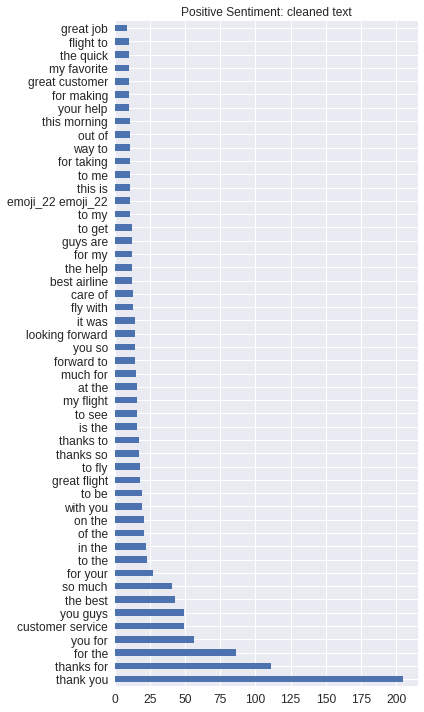

Index(['thank you', 'thanks for', 'for the', 'you for', 'customer service',
       'you guys', 'the best', 'so much', 'for your', 'to the', 'in the',
       'of the', 'on the', 'with you', 'to be', 'great flight', 'to fly',
       'thanks so', 'thanks to', 'is the', 'to see', 'my flight', 'at the',
       'much for', 'forward to', 'you so', 'looking forward', 'it was',
       'fly with', 'care of', 'best airline', 'the help', 'for my', 'guys are',
       'to get', 'to my', 'emoji_22 emoji_22', 'this is', 'to me',
       'for taking', 'way to', 'out of', 'this morning', 'your help',
       'for making', 'great customer', 'my favorite', 'the quick', 'flight to',
       'great job'],
      dtype='object')


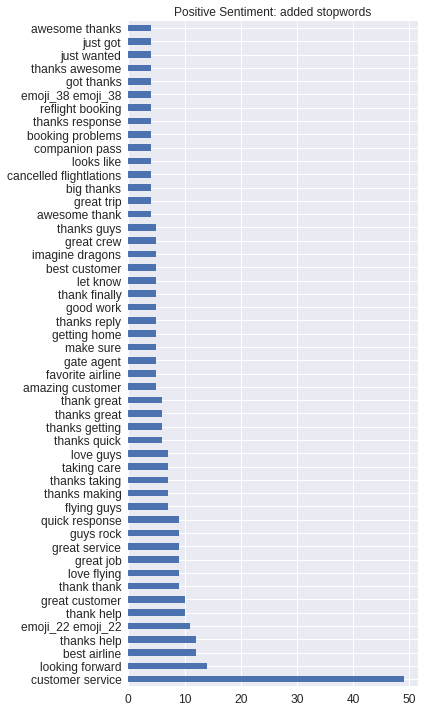

Index(['customer service', 'looking forward', 'best airline', 'thanks help',
       'emoji_22 emoji_22', 'thank help', 'great customer', 'thank thank',
       'love flying', 'great job', 'great service', 'guys rock',
       'quick response', 'flying guys', 'thanks making', 'thanks taking',
       'taking care', 'love guys', 'thanks quick', 'thanks getting',
       'thanks great', 'thank great', 'amazing customer', 'favorite airline',
       'gate agent', 'make sure', 'getting home', 'thanks reply', 'good work',
       'thank finally', 'let know', 'best customer', 'imagine dragons',
       'great crew', 'thanks guys', 'awesome thank', 'great trip',
       'big thanks', 'cancelled flightlations', 'looks like', 'companion pass',
       'booking problems', 'thanks response', 'reflight booking',
       'emoji_38 emoji_38', 'got thanks', 'thanks awesome', 'just wanted',
       'just got', 'awesome thanks'],
      dtype='object')


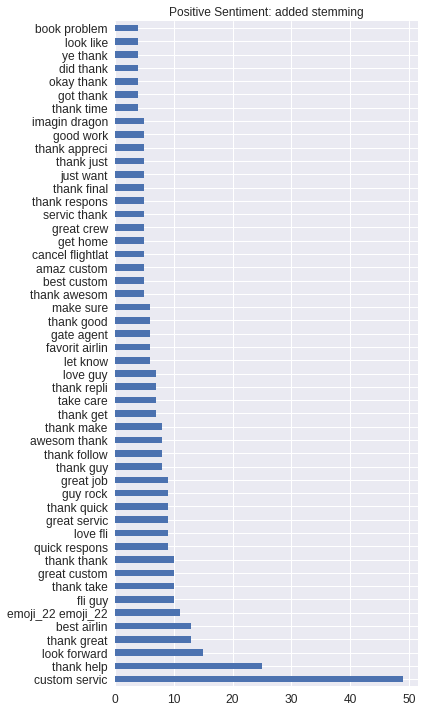

Index(['custom servic', 'thank help', 'look forward', 'thank great',
       'best airlin', 'emoji_22 emoji_22', 'fli guy', 'thank take',
       'great custom', 'thank thank', 'quick respons', 'love fli',
       'great servic', 'thank quick', 'guy rock', 'great job', 'thank guy',
       'thank follow', 'awesom thank', 'thank make', 'thank get', 'take care',
       'thank repli', 'love guy', 'let know', 'favorit airlin', 'gate agent',
       'thank good', 'make sure', 'thank awesom', 'best custom', 'amaz custom',
       'cancel flightlat', 'get home', 'great crew', 'servic thank',
       'thank respons', 'thank final', 'just want', 'thank just',
       'thank appreci', 'good work', 'imagin dragon', 'thank time',
       'got thank', 'okay thank', 'did thank', 'ye thank', 'look like',
       'book problem'],
      dtype='object')


In [127]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

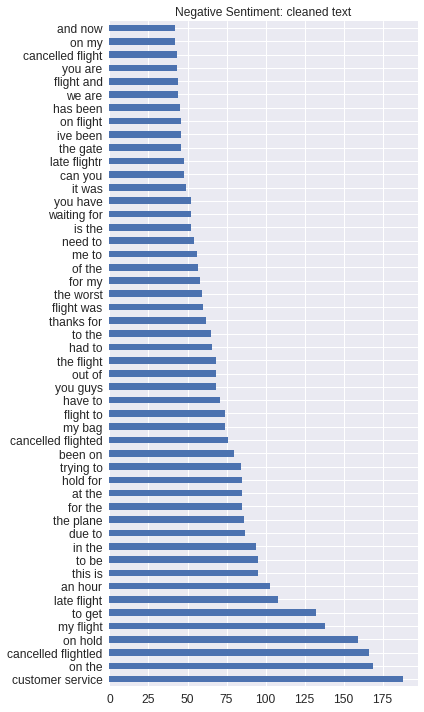

Index(['customer service', 'on the', 'cancelled flightled', 'on hold',
       'my flight', 'to get', 'late flight', 'an hour', 'this is', 'to be',
       'in the', 'due to', 'the plane', 'for the', 'at the', 'hold for',
       'trying to', 'been on', 'cancelled flighted', 'my bag', 'flight to',
       'have to', 'you guys', 'out of', 'the flight', 'had to', 'to the',
       'thanks for', 'flight was', 'the worst', 'for my', 'of the', 'me to',
       'need to', 'is the', 'waiting for', 'you have', 'it was', 'can you',
       'late flightr', 'the gate', 'ive been', 'on flight', 'has been',
       'we are', 'flight and', 'you are', 'cancelled flight', 'on my',
       'and now'],
      dtype='object')


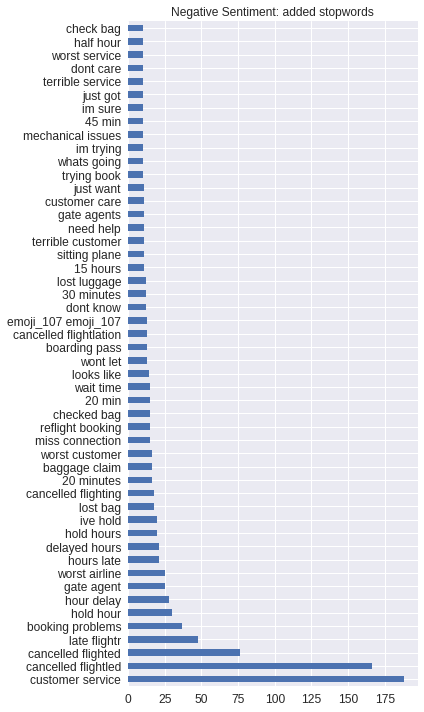

Index(['customer service', 'cancelled flightled', 'cancelled flighted',
       'late flightr', 'booking problems', 'hold hour', 'hour delay',
       'gate agent', 'worst airline', 'hours late', 'delayed hours',
       'hold hours', 'ive hold', 'lost bag', 'cancelled flighting',
       '20 minutes', 'baggage claim', 'worst customer', 'miss connection',
       'reflight booking', 'checked bag', '20 min', 'wait time', 'looks like',
       'wont let', 'boarding pass', 'cancelled flightlation',
       'emoji_107 emoji_107', 'dont know', '30 minutes', 'lost luggage',
       '15 hours', 'sitting plane', 'terrible customer', 'need help',
       'gate agents', 'customer care', 'just want', 'trying book',
       'whats going', 'im trying', 'mechanical issues', '45 min', 'im sure',
       'just got', 'terrible service', 'dont care', 'worst service',
       'half hour', 'check bag'],
      dtype='object')


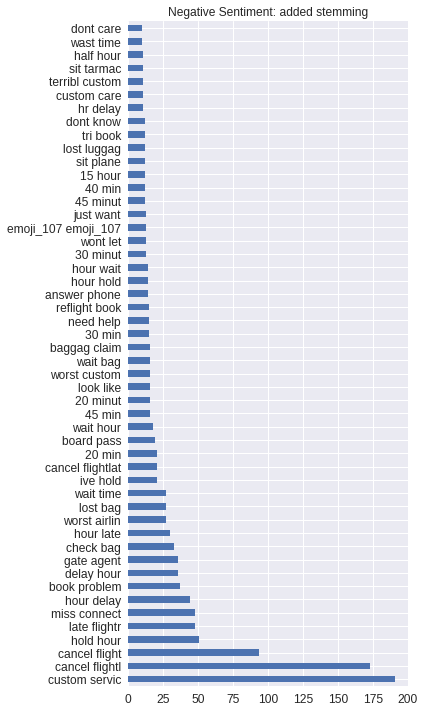

Index(['custom servic', 'cancel flightl', 'cancel flight', 'hold hour',
       'late flightr', 'miss connect', 'hour delay', 'book problem',
       'delay hour', 'gate agent', 'check bag', 'hour late', 'worst airlin',
       'lost bag', 'wait time', 'ive hold', 'cancel flightlat', '20 min',
       'board pass', 'wait hour', '45 min', '20 minut', 'look like',
       'worst custom', 'wait bag', 'baggag claim', '30 min', 'need help',
       'reflight book', 'answer phone', 'hour hold', 'hour wait', '30 minut',
       'wont let', 'emoji_107 emoji_107', 'just want', '45 minut', '40 min',
       '15 hour', 'sit plane', 'lost luggag', 'tri book', 'dont know',
       'hr delay', 'custom care', 'terribl custom', 'sit tarmac', 'half hour',
       'wast time', 'dont care'],
      dtype='object')


In [128]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

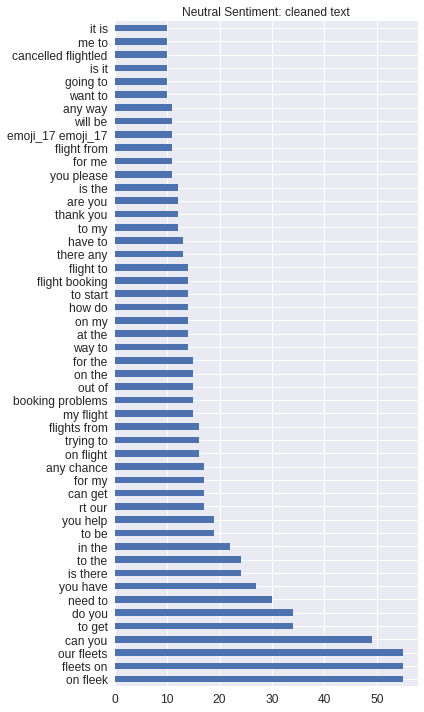

Index(['on fleek', 'fleets on', 'our fleets', 'can you', 'to get', 'do you',
       'need to', 'you have', 'is there', 'to the', 'in the', 'to be',
       'you help', 'rt our', 'can get', 'for my', 'any chance', 'on flight',
       'trying to', 'flights from', 'my flight', 'booking problems', 'out of',
       'on the', 'for the', 'way to', 'at the', 'on my', 'how do', 'to start',
       'flight booking', 'flight to', 'there any', 'have to', 'to my',
       'thank you', 'are you', 'is the', 'you please', 'for me', 'flight from',
       'emoji_17 emoji_17', 'will be', 'any way', 'want to', 'going to',
       'is it', 'cancelled flightled', 'me to', 'it is'],
      dtype='object')


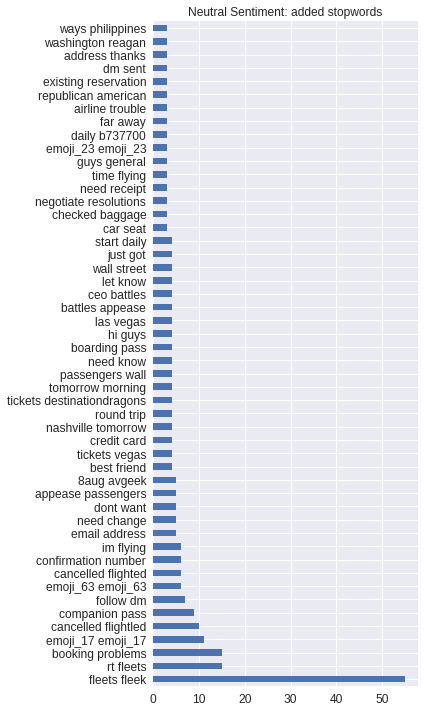

Index(['fleets fleek', 'rt fleets', 'booking problems', 'emoji_17 emoji_17',
       'cancelled flightled', 'companion pass', 'follow dm',
       'emoji_63 emoji_63', 'cancelled flighted', 'confirmation number',
       'im flying', 'email address', 'need change', 'dont want',
       'appease passengers', '8aug avgeek', 'best friend', 'tickets vegas',
       'credit card', 'nashville tomorrow', 'round trip',
       'tickets destinationdragons', 'tomorrow morning', 'passengers wall',
       'need know', 'boarding pass', 'hi guys', 'las vegas', 'battles appease',
       'ceo battles', 'let know', 'wall street', 'just got', 'start daily',
       'car seat', 'checked baggage', 'negotiate resolutions', 'need receipt',
       'time flying', 'guys general', 'emoji_23 emoji_23', 'daily b737700',
       'far away', 'airline trouble', 'republican american',
       'existing reservation', 'dm sent', 'address thanks',
       'washington reagan', 'ways philippines'],
      dtype='object')


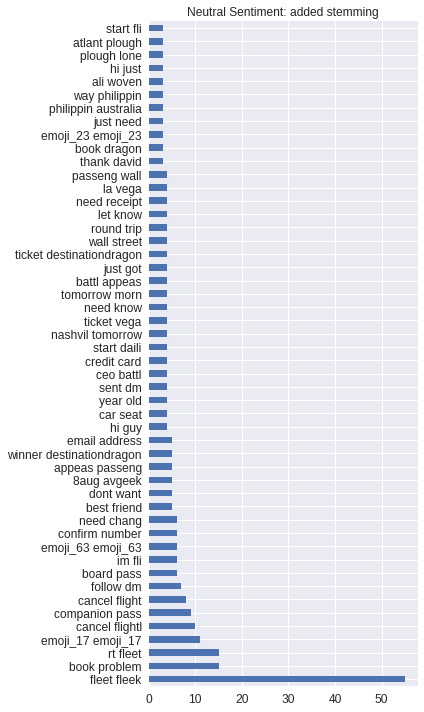

Index(['fleet fleek', 'book problem', 'rt fleet', 'emoji_17 emoji_17',
       'cancel flightl', 'companion pass', 'cancel flight', 'follow dm',
       'board pass', 'im fli', 'emoji_63 emoji_63', 'confirm number',
       'need chang', 'best friend', 'dont want', '8aug avgeek',
       'appeas passeng', 'winner destinationdragon', 'email address', 'hi guy',
       'car seat', 'year old', 'sent dm', 'ceo battl', 'credit card',
       'start daili', 'nashvil tomorrow', 'ticket vega', 'need know',
       'tomorrow morn', 'battl appeas', 'just got', 'ticket destinationdragon',
       'wall street', 'round trip', 'let know', 'need receipt', 'la vega',
       'passeng wall', 'thank david', 'book dragon', 'emoji_23 emoji_23',
       'just need', 'philippin australia', 'way philippin', 'ali woven',
       'hi just', 'plough lone', 'atlant plough', 'start fli'],
      dtype='object')


In [129]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at tri-grams

In [130]:
grams = "Trigrams"

In [131]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(3,3))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(3,3))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(3,3))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [132]:
print(words_df.shape)
words_df.head(1)

(5656, 68410)


,0162431184663 of your,0167560070877 fsqthg thanks,0214 when this,021mbps amp ended,03 for flight,0510 in santo,0510 the captain,0530 flight out,0769 out of,10 baggage claim,...,zero to keep,zero to protect,zero updates unitedairlinessux,zone while get,zone your actually,zoom out or,zrh departed 245hrs,zukes nonvegan yogurt,zurich bc of,zurich why would
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
print(words_stop_df.shape)
words_stop_df.head(1)

(5656, 33268)


,0162431184663 agents said,0167560070877 fsqthg thanks,0214 started phone,021mbps ended watching,03 booking problems,0510 captain informs,0510 santo domingo,0530 dfw tuesday,0769 lga dfw,10 1115p construction,...,zero meaningful assistance,zero people stepping,zero protect daughter,zero safealone plastic,zero updates unitedairlinessux,zoom scroll touch,zrh departed 245hrs,zukes nonvegan yogurt,zurich bc fault,zurich credit miles
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
print(words_stem_df.shape)
words_stem_df.head(1)

(5656, 33068)


,0162431184663 agent said,0167560070877 fsqthg thank,0214 start phone,021mbp end watch,03 book problem,0510 captain inform,0510 santo domingo,0530 dfw tuesday,0769 lga dfw,10 1115p construct,...,zero meaning assist,zero peopl step,zero protect daughter,zero safealon plastic,zero updat unitedairlinessux,zoom scroll touch,zrh depart 245hr,zuke nonvegan yogurt,zurich bc fault,zurich credit mile
airline_sentiment,,,,,,,,,,,,,,,,,,,,,
neutral,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
# dimensionality reduced from 68410, to 33268, 33068

## Positive

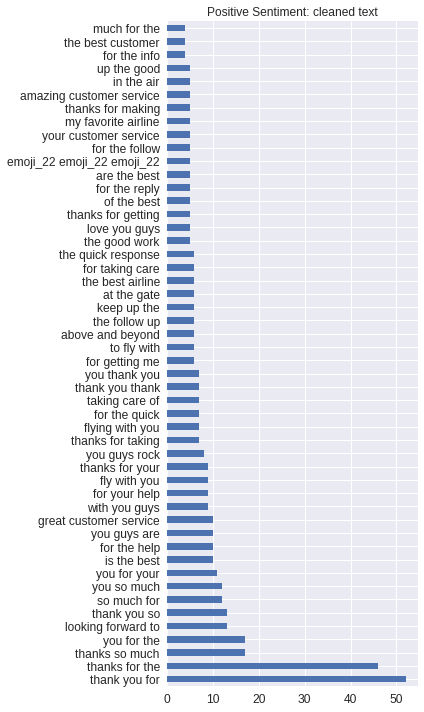

Index(['thank you for', 'thanks for the', 'thanks so much', 'you for the',
       'looking forward to', 'thank you so', 'so much for', 'you so much',
       'you for your', 'is the best', 'for the help', 'you guys are',
       'great customer service', 'with you guys', 'for your help',
       'fly with you', 'thanks for your', 'you guys rock', 'thanks for taking',
       'flying with you', 'for the quick', 'taking care of', 'thank you thank',
       'you thank you', 'for getting me', 'to fly with', 'above and beyond',
       'the follow up', 'keep up the', 'at the gate', 'the best airline',
       'for taking care', 'the quick response', 'the good work',
       'love you guys', 'thanks for getting', 'of the best', 'for the reply',
       'are the best', 'emoji_22 emoji_22 emoji_22', 'for the follow',
       'your customer service', 'my favorite airline', 'thanks for making',
       'amazing customer service', 'in the air', 'up the good', 'for the info',
       'the best customer', 'muc

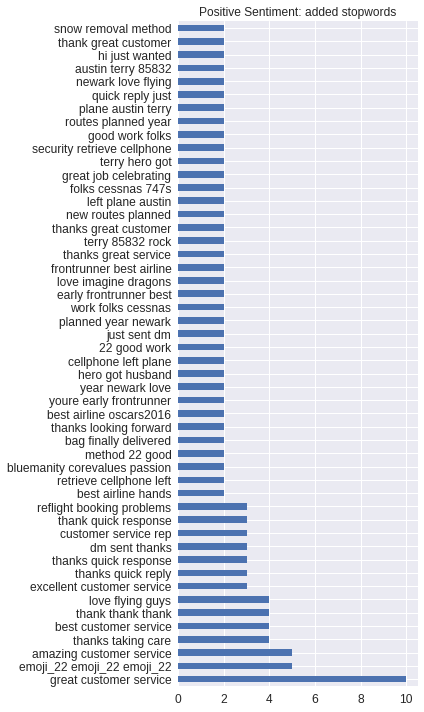

Index(['great customer service', 'emoji_22 emoji_22 emoji_22',
       'amazing customer service', 'thanks taking care',
       'best customer service', 'thank thank thank', 'love flying guys',
       'excellent customer service', 'thanks quick reply',
       'thanks quick response', 'dm sent thanks', 'customer service rep',
       'thank quick response', 'reflight booking problems',
       'best airline hands', 'retrieve cellphone left',
       'bluemanity corevalues passion', 'method 22 good',
       'bag finally delivered', 'thanks looking forward',
       'best airline oscars2016', 'youre early frontrunner',
       'year newark love', 'hero got husband', 'cellphone left plane',
       '22 good work', 'just sent dm', 'planned year newark',
       'work folks cessnas', 'early frontrunner best', 'love imagine dragons',
       'frontrunner best airline', 'thanks great service', 'terry 85832 rock',
       'thanks great customer', 'new routes planned', 'left plane austin',
       'folks c

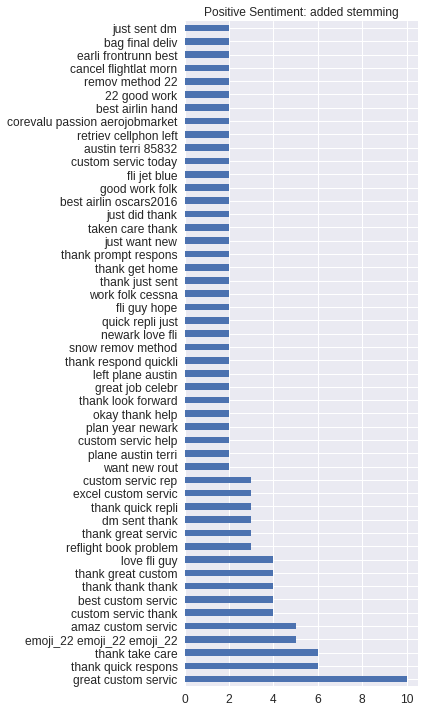

Index(['great custom servic', 'thank quick respons', 'thank take care',
       'emoji_22 emoji_22 emoji_22', 'amaz custom servic',
       'custom servic thank', 'best custom servic', 'thank thank thank',
       'thank great custom', 'love fli guy', 'reflight book problem',
       'thank great servic', 'dm sent thank', 'thank quick repli',
       'excel custom servic', 'custom servic rep', 'want new rout',
       'plane austin terri', 'custom servic help', 'plan year newark',
       'okay thank help', 'thank look forward', 'great job celebr',
       'left plane austin', 'thank respond quickli', 'snow remov method',
       'newark love fli', 'quick repli just', 'fli guy hope',
       'work folk cessna', 'thank just sent', 'thank get home',
       'thank prompt respons', 'just want new', 'taken care thank',
       'just did thank', 'best airlin oscars2016', 'good work folk',
       'fli jet blue', 'custom servic today', 'austin terri 85832',
       'retriev cellphon left', 'corevalu passi

In [136]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

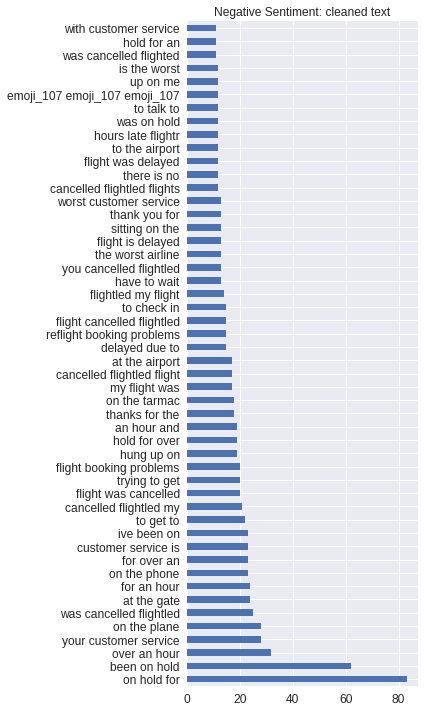

Index(['on hold for', 'been on hold', 'over an hour', 'your customer service',
       'on the plane', 'was cancelled flightled', 'at the gate', 'for an hour',
       'on the phone', 'for over an', 'customer service is', 'ive been on',
       'to get to', 'cancelled flightled my', 'flight was cancelled',
       'trying to get', 'flight booking problems', 'hung up on',
       'hold for over', 'an hour and', 'thanks for the', 'on the tarmac',
       'my flight was', 'cancelled flightled flight', 'at the airport',
       'delayed due to', 'reflight booking problems',
       'flight cancelled flightled', 'to check in', 'flightled my flight',
       'have to wait', 'you cancelled flightled', 'the worst airline',
       'flight is delayed', 'sitting on the', 'thank you for',
       'worst customer service', 'cancelled flightled flights', 'there is no',
       'flight was delayed', 'to the airport', 'hours late flightr',
       'was on hold', 'to talk to', 'emoji_107 emoji_107 emoji_107',
    

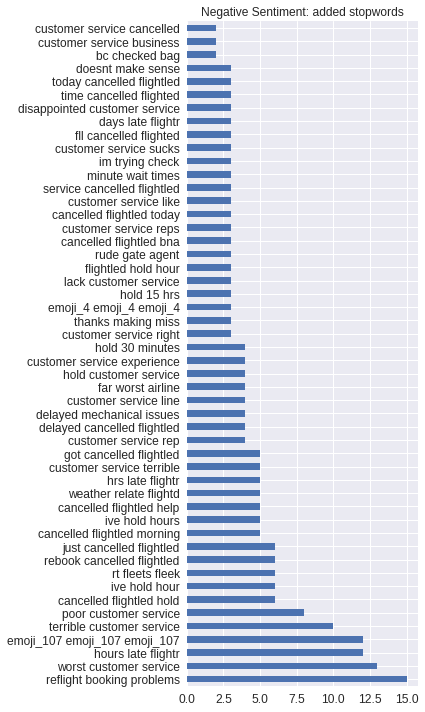

Index(['reflight booking problems', 'worst customer service',
       'hours late flightr', 'emoji_107 emoji_107 emoji_107',
       'terrible customer service', 'poor customer service',
       'cancelled flightled hold', 'ive hold hour', 'rt fleets fleek',
       'rebook cancelled flightled', 'just cancelled flightled',
       'cancelled flightled morning', 'ive hold hours',
       'cancelled flightled help', 'weather relate flightd',
       'hrs late flightr', 'customer service terrible',
       'got cancelled flightled', 'customer service rep',
       'delayed cancelled flightled', 'delayed mechanical issues',
       'customer service line', 'far worst airline', 'hold customer service',
       'customer service experience', 'hold 30 minutes',
       'customer service right', 'thanks making miss',
       'emoji_4 emoji_4 emoji_4', 'hold 15 hrs', 'lack customer service',
       'flightled hold hour', 'rude gate agent', 'cancelled flightled bna',
       'customer service reps', 'cancelle

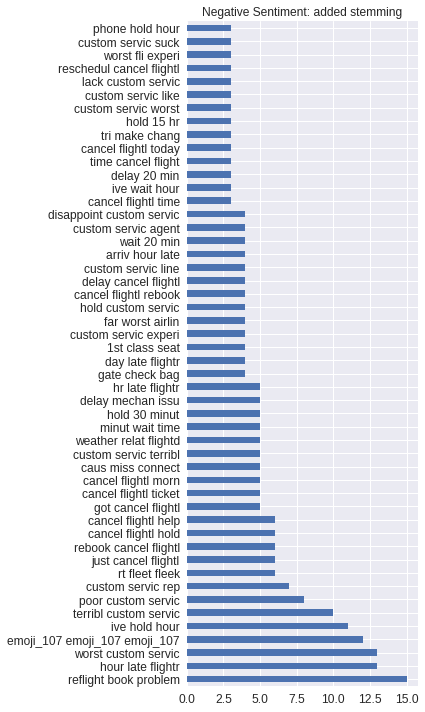

Index(['reflight book problem', 'hour late flightr', 'worst custom servic',
       'emoji_107 emoji_107 emoji_107', 'ive hold hour',
       'terribl custom servic', 'poor custom servic', 'custom servic rep',
       'rt fleet fleek', 'just cancel flightl', 'rebook cancel flightl',
       'cancel flightl hold', 'cancel flightl help', 'got cancel flightl',
       'cancel flightl ticket', 'cancel flightl morn', 'caus miss connect',
       'custom servic terribl', 'weather relat flightd', 'minut wait time',
       'hold 30 minut', 'delay mechan issu', 'hr late flightr',
       'gate check bag', 'day late flightr', '1st class seat',
       'custom servic experi', 'far worst airlin', 'hold custom servic',
       'cancel flightl rebook', 'delay cancel flightl', 'custom servic line',
       'arriv hour late', 'wait 20 min', 'custom servic agent',
       'disappoint custom servic', 'cancel flightl time', 'ive wait hour',
       'delay 20 min', 'time cancel flight', 'cancel flightl today',
      

In [137]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

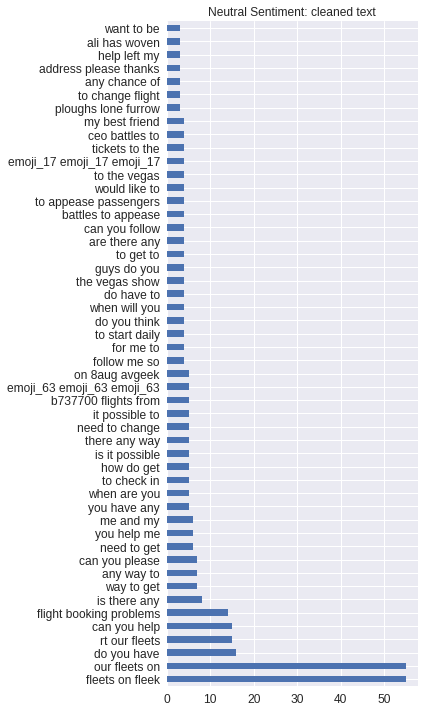

Index(['fleets on fleek', 'our fleets on', 'do you have', 'rt our fleets',
       'can you help', 'flight booking problems', 'is there any', 'way to get',
       'any way to', 'can you please', 'need to get', 'you help me',
       'me and my', 'you have any', 'when are you', 'to check in',
       'how do get', 'is it possible', 'there any way', 'need to change',
       'it possible to', 'b737700 flights from', 'emoji_63 emoji_63 emoji_63',
       'on 8aug avgeek', 'follow me so', 'for me to', 'to start daily',
       'do you think', 'when will you', 'do have to', 'the vegas show',
       'guys do you', 'to get to', 'are there any', 'can you follow',
       'battles to appease', 'to appease passengers', 'would like to',
       'to the vegas', 'emoji_17 emoji_17 emoji_17', 'tickets to the',
       'ceo battles to', 'my best friend', 'ploughs lone furrow',
       'to change flight', 'any chance of', 'address please thanks',
       'help left my', 'ali has woven', 'want to be'],
      dtyp

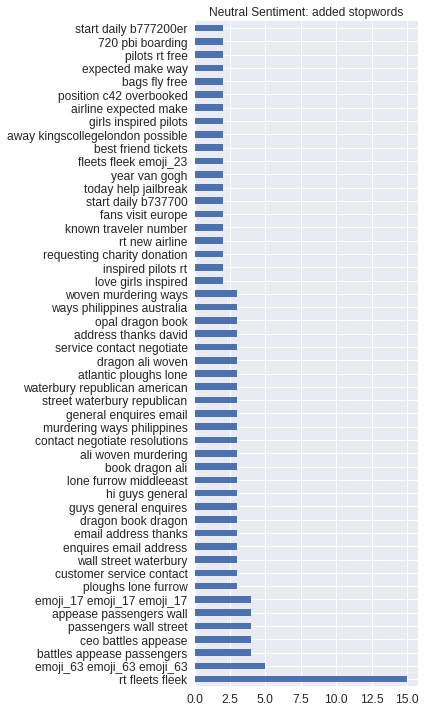

Index(['rt fleets fleek', 'emoji_63 emoji_63 emoji_63',
       'battles appease passengers', 'ceo battles appease',
       'passengers wall street', 'appease passengers wall',
       'emoji_17 emoji_17 emoji_17', 'ploughs lone furrow',
       'customer service contact', 'wall street waterbury',
       'enquires email address', 'email address thanks', 'dragon book dragon',
       'guys general enquires', 'hi guys general', 'lone furrow middleeast',
       'book dragon ali', 'ali woven murdering',
       'contact negotiate resolutions', 'murdering ways philippines',
       'general enquires email', 'street waterbury republican',
       'waterbury republican american', 'atlantic ploughs lone',
       'dragon ali woven', 'service contact negotiate', 'address thanks david',
       'opal dragon book', 'ways philippines australia',
       'woven murdering ways', 'love girls inspired', 'inspired pilots rt',
       'requesting charity donation', 'rt new airline',
       'known traveler number',

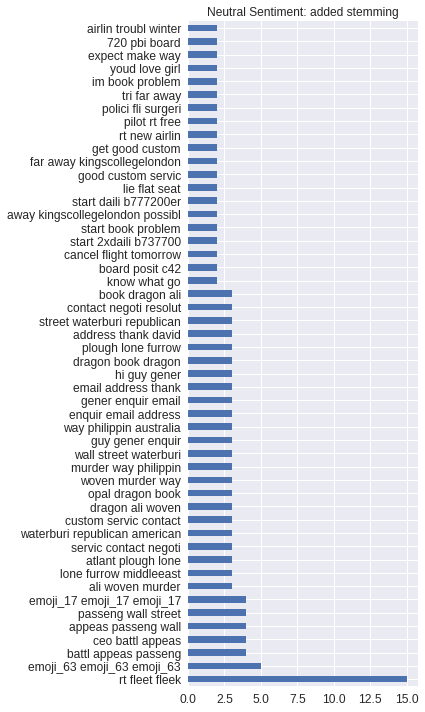

Index(['rt fleet fleek', 'emoji_63 emoji_63 emoji_63', 'battl appeas passeng',
       'ceo battl appeas', 'appeas passeng wall', 'passeng wall street',
       'emoji_17 emoji_17 emoji_17', 'ali woven murder',
       'lone furrow middleeast', 'atlant plough lone', 'servic contact negoti',
       'waterburi republican american', 'custom servic contact',
       'dragon ali woven', 'opal dragon book', 'woven murder way',
       'murder way philippin', 'wall street waterburi', 'guy gener enquir',
       'way philippin australia', 'enquir email address', 'gener enquir email',
       'email address thank', 'hi guy gener', 'dragon book dragon',
       'plough lone furrow', 'address thank david',
       'street waterburi republican', 'contact negoti resolut',
       'book dragon ali', 'know what go', 'board posit c42',
       'cancel flight tomorrow', 'start 2xdaili b737700', 'start book problem',
       'away kingscollegelondon possibl', 'start daili b777200er',
       'lie flat seat', 'good c

In [138]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

In [54]:
# Pickle dataframe with added columns with processed and cleaned text.
import pickle

In [55]:
data_out_dir

'data/pickled/EDA_NB1_emoji_encoding/'

In [56]:
filename = data_out_dir+'airline_cl_process_dataset_df1'
filehandler = open(filename,"wb")
pickle.dump(air_sub_df,filehandler)

In [108]:
file = open(filename,'rb')
object_content = pickle.load(file)

In [ ]:
#**************** I did not encode emojis. What did count vectorizer do with them? Let's explore.

In [110]:
# emoji in text.
text1 = air_sub_df.loc[42, 'clean_text']
text2 = air_sub_df.loc[42, 'stopw_clean_text']

In [111]:
text1, text2

('plz help me win my bid upgrade for my flight 227 laxgtsea  EMOJI_8 EMOJI_3 EMOJI_9 EMOJI_7️',
 'plz help win bid upgrade 227 laxgtsea EMOJI_8 EMOJI_3 EMOJI_9 EMOJI_7️')

In [112]:
def disp_transformed_text_tokens(vectorizer, text):
    text_vect = vectorizer.transform([text])
    text_df = pd.DataFrame(text_vect.toarray(), columns=vectorizer.get_feature_names())
    words = text_df.sum().sort_values(ascending=False)
    words.head(10).plot(kind='barh',figsize=(3,4), fontsize=12)
    print(text)
    plt.show()

plz help me win my bid upgrade for my flight 227 laxgtsea  EMOJI_8 EMOJI_3 EMOJI_9 EMOJI_7️


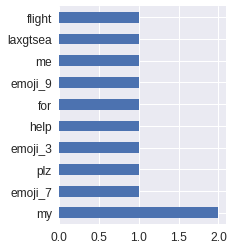

plz help win bid upgrade 227 laxgtsea EMOJI_8 EMOJI_3 EMOJI_9 EMOJI_7️


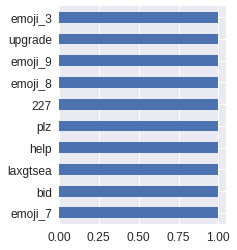

In [116]:
disp_transformed_text_tokens(cv, text1)
disp_transformed_text_tokens(cv, text2)

In [117]:
reverse_lookup_emoji_dict['EMOJI_8'], reverse_lookup_emoji_dict['EMOJI_3'], reverse_lookup_emoji_dict['EMOJI_9'], reverse_lookup_emoji_dict['EMOJI_8'],reverse_lookup_emoji_dict['EMOJI_7'] 

('🍷', '👍', '💺', '🍷', '✈')

In [ ]:
# Emojis are encoded. Now use this data for modelling and see what effects
# emojis have on predictions. Explore this further in another notebook.